### **1.0) Bibliotecas Necessárias**

In [1]:
#######################################################################
# Bibliotecas Principais
#######################################################################
import pandas as pd
from pathlib import Path
import pickle 
from datetime import datetime
from datetime import time
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from statsmodels.tsa.seasonal import seasonal_decompose
from IPython.display import display, Markdown   
from sklearn.ensemble import IsolationForest
from pywaffle import Waffle
import calplot
from scipy.stats.mstats import winsorize
from scipy import special
from pyod.models.mad import MAD


In [2]:
def univariate_chauvenet(data_points: np.ndarray, criterion: float = None):
    # Calculate mean and std of the data
    mean = data_points.mean()
    std = data_points.std()

    # Calculate the criterion based on the number of points if not provided
    if criterion is None:
        criterion = 1.0/(2 * len(data_points)) ## criterion is set to 1 divided 2 times the length of the data set.

    # Calculate the absolute deviation and scale by std
    deviation = np.abs(data_points - mean) / std

    # Calculate the probabilities using erfc and return the mask. Erfc is the error function calculating the probability of a data point (not) being an outlier.
    # if the probability is lower than the criterion (so the likelihood that the data point is no outlier is smaller than the set criterion), it is an outlier.
    probabilities = special.erfc(deviation)
    return probabilities < criterion

In [3]:
def WaffleChart ( dictDados, strTitulo, iVertical = False, iTamnhoIcone = 12, icon = [], cmapName = 'Pastel2', iLargura = 10, iAltura = 6, iLinhas = 5, iColunas = 20 ):
    plt.figure  (
                cmap_name = cmapName, 
                font_size = iTamnhoIcone, 
                vertical = iVertical,
                FigureClass = Waffle, 
                figsize = (iLargura, iAltura),
                rows = iLinhas, 
                columns = iColunas,
                values = dictDados, 
                icons = icon, 
                title = {
                        'label': strTitulo, 
                        'loc': 'left',
                        'fontdict': {
                                        'fontsize': 12, 
                                        "fontweight":"bold"
                                    }
                        },
                labels = ["{0} ({1} Registros)".format(k, v) for k, v in dictDados.items()],
                legend = {
                            'loc': 'lower left', 
                            'bbox_to_anchor': (0, -0.2), 
                            'ncol': 3, 
                            'framealpha': 0
                        }
                )

In [4]:
def detect_outliers_iqr(df, features):
    
    outlier_indices = []    
    for col in features:
        Q1 = np.percentile(df[col], 25)
        Q3 = np.percentile(df[col], 75)
        
        IQR = Q3 - Q1
        outlier_step = 1.5 * IQR   
        outlier_list_col = df[(df[col] < Q1 - outlier_step) | (df[col] > Q3 + outlier_step)].index        
        outlier_indices.extend(outlier_list_col)
            
    return outlier_indices

In [5]:
def detect_outliers_normal(df, features):
    
    for col in features:        
        height_outlier_mean = df[col].mean()
        height_outlier_std = df[col].std()
        
        non_outlier_interval_dist = [height_outlier_mean - 2 * height_outlier_std, height_outlier_mean + 2 * height_outlier_std]        
        outliers_dist = df[(df[col] < non_outlier_interval_dist[0]) | (df[col] > non_outlier_interval_dist[1])].index
        
        return outliers_dist

#### **2.0) Definições Globais**

In [6]:
########################################################################
# Definições Gerais
########################################################################
Arquivo = "https://raw.githubusercontent.com/numenta/NAB/master/data/realKnownCause/ambient_temperature_system_failure.csv"
# colors = ["blue", "green", "red", "black", "tomato", "orange", "sienna", "goldenrod", "teal", "steelblue", "deeppink", "olive"]


#### **3.0) Leitura dos Dados Originais**

In [7]:
DadosBase = pd.read_csv ( Arquivo ) 
DadosBase = DadosBase.dropna(how = 'any', axis = 0)
dfOriginal = DadosBase.copy()

#### **3.1) Ajustes e Criação de Novos Dados**

In [8]:
DadosBase['timestamp'] = pd.to_datetime(DadosBase['timestamp'])
DadosBase["Date"] = DadosBase['timestamp'].dt.date
DadosBase['Date'] = pd.to_datetime(DadosBase['Date'])

#### **3.2) Comportamento dos Dados em Todos os Anos**

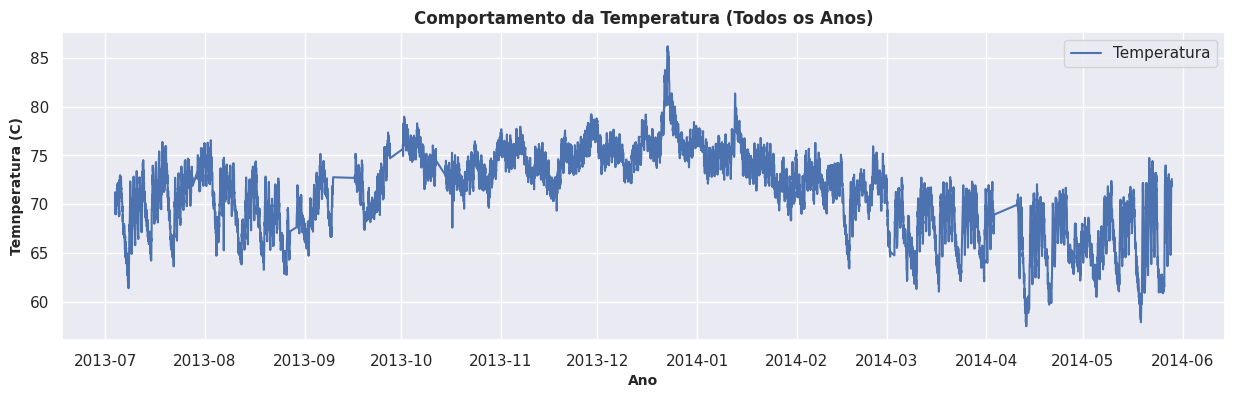

In [9]:
df_plot = DadosBase[["timestamp",'value']].copy()
df_plot = df_plot.set_index('timestamp')

plt.figure(figsize=(15, 4))
sns.set_theme(style="darkgrid")

plt.plot(df_plot.index, df_plot["value"], label='Temperatura')
plt.title("Comportamento da Temperatura (Todos os Anos)", fontsize=12, fontweight="bold" )
plt.ylabel('Temnperatura (C)', fontweight="bold", fontsize=10)
plt.xlabel ('Ano', fontweight="bold", fontsize=10)

plt.legend()
plt.show ()

In [10]:
df_plot = DadosBase[["timestamp",'value']].copy()
df_plot = df_plot.set_index('timestamp')
# df_plot

In [11]:
dfOriginal['timestamp'] = pd.to_datetime(DadosBase['timestamp'])
dfOriginal['Date'] = DadosBase['timestamp'].dt.date
dfOriginal = DadosBase.drop('timestamp', axis=1)
dfOriginal['Date'] = pd.to_datetime(DadosBase['Date'])
dfOriginal = DadosBase.set_index('Date')
# dfOriginal


findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.


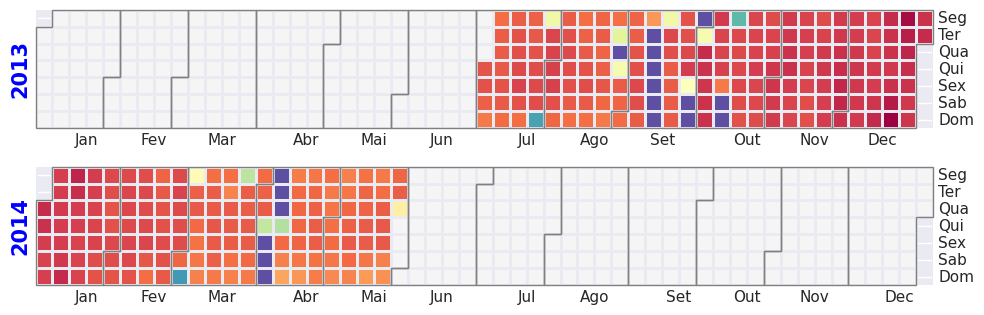

In [12]:

ylabel_kws = dict   (
                        fontsize=30,
                        color='gray',
                        fontname='Arial',
                        fontweight='bold',
                        ha='center'
                    )

ylabel_kws.update(ylabel_kws)
calplot.calplot (
                    dfOriginal['value'], 
                    cmap = 'Spectral_r', 
                    colorbar=False,
                    yearlabels = True,  
                    yearlabel_kws = {
                                        'fontname':'Arial',
                                        'fontsize': 15, 
                                        'color': 'blue'
                                    }, 
                    daylabels = [
                                    'Seg', 'Ter', 
                                    'Qua', 'Qui', 
                                    'Sex', 'Sab', 
                                    'Dom'
                                ],
                    monthlabels = [
                                    'Jan', 'Fev', 'Mar', 
                                    'Abr', 'Mai', 'Jun',
                                    'Jul', 'Ago', 'Set',
                                    'Out', 'Nov', 'Dec']
                );

#### **4.0) Histograma dos Dados**

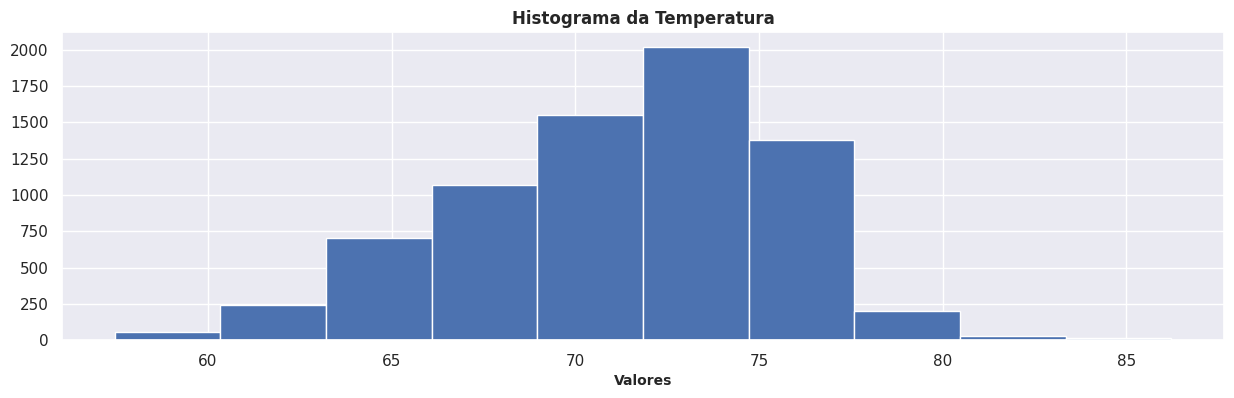

In [13]:
df_plot = DadosBase[["timestamp",'value']].copy()
df_plot = df_plot.set_index('timestamp')

Media = df_plot.mean()
DesvioPadrao = df_plot.std()

plt.figure(figsize=(15, 4))
sns.set_theme(style="darkgrid")
plt.hist(df_plot)

plt.title("Histograma da Temperatura", fontsize=12, fontweight="bold" )
# plt.ylabel('Temnperatura (C)', fontweight="bold", fontsize=10)
plt.xlabel ('Valores', fontweight="bold", fontsize=10)
plt.show ()

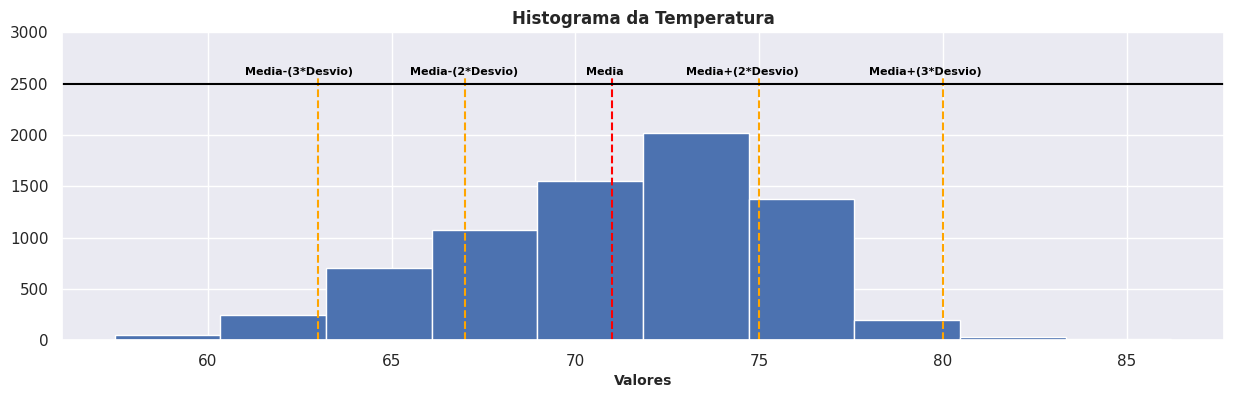

In [14]:
df_plot = DadosBase[["timestamp",'value']].copy()
df_plot = df_plot.set_index('timestamp')

Media = df_plot.mean()
DesvioPadrao = df_plot.std()

plt.figure(figsize=(15, 4))
sns.set_theme(style="darkgrid")
plt.hist(df_plot)

plt.axvline(x = 71, ymin = 0, ymax = 0.85, color ='red', linestyle='--' ) 
plt.axvline(x = 75, ymin = 0, ymax = 0.85, color ='orange', linestyle='--' )  
plt.axvline(x = 80, ymin = 0, ymax = 0.85, color ='orange', linestyle='--' )  
plt.axvline(x = 67, ymin = 0, ymax = 0.85, color ='orange', linestyle='--' )  
plt.axvline(x = 63, ymin = 0, ymax = 0.85, color ='orange', linestyle='--' )  
plt.axhline(2500, color ='black') 

plt.ylim (0, 3000)
plt.text(70.3, 2580, "Media", color ='black', fontsize = 8, fontweight="bold")
plt.text(73, 2580, "Media+(2*Desvio)", color ='black', fontsize = 8, fontweight="bold")
plt.text(78, 2580, "Media+(3*Desvio)", color ='black', fontsize = 8, fontweight="bold")

plt.text(65.5, 2580, "Media-(2*Desvio)", color ='black', fontsize = 8, fontweight="bold")
plt.text(61, 2580, "Media-(3*Desvio)", color ='black', fontsize = 8, fontweight="bold")

plt.title("Histograma da Temperatura", fontsize=12, fontweight="bold" )
# plt.ylabel('Temnperatura (C)', fontweight="bold", fontsize=10)
plt.xlabel ('Valores', fontweight="bold", fontsize=10)
plt.show ()

#### **4.1) Avaliação do Lag da Série Temporal**

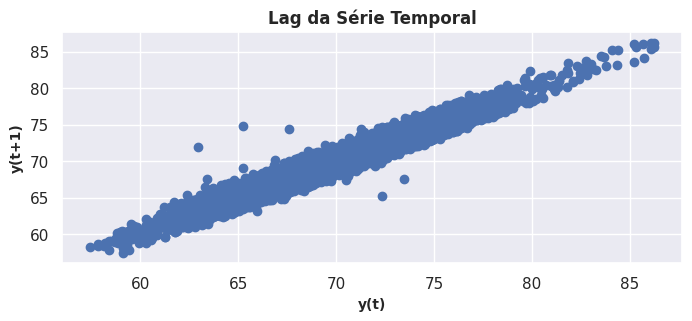

In [15]:
plt.figure(figsize=(8, 3))
sns.set_theme(style="darkgrid")

pd.plotting.lag_plot(DadosBase['value'])
plt.title("Lag da Série Temporal", fontsize=12, fontweight="bold" )
plt.ylabel('y(t+1)', fontweight="bold", fontsize=10)
plt.xlabel ('y(t)', fontweight="bold", fontsize=10)
plt.show ()


#### **4.2) Conhecendo os Outliers**

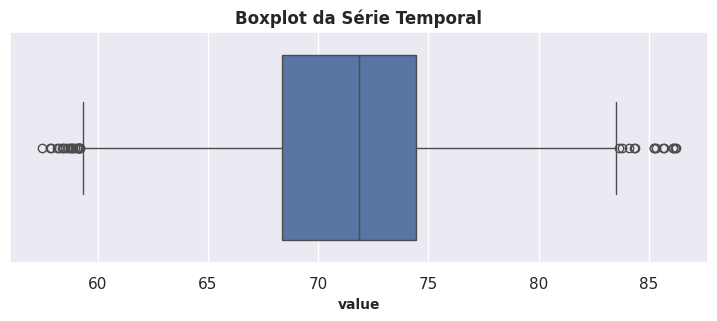

In [16]:
plt.figure(figsize=(9, 3))
sns.set_theme(style="darkgrid")

sns.boxplot(data = DadosBase, x = 'value')

plt.title("Boxplot da Série Temporal", fontsize=12, fontweight="bold" )
plt.xlabel ('value', fontweight="bold", fontsize=10)
plt.show ()


#### **5.0) Calculando o ZScore dos Dados**

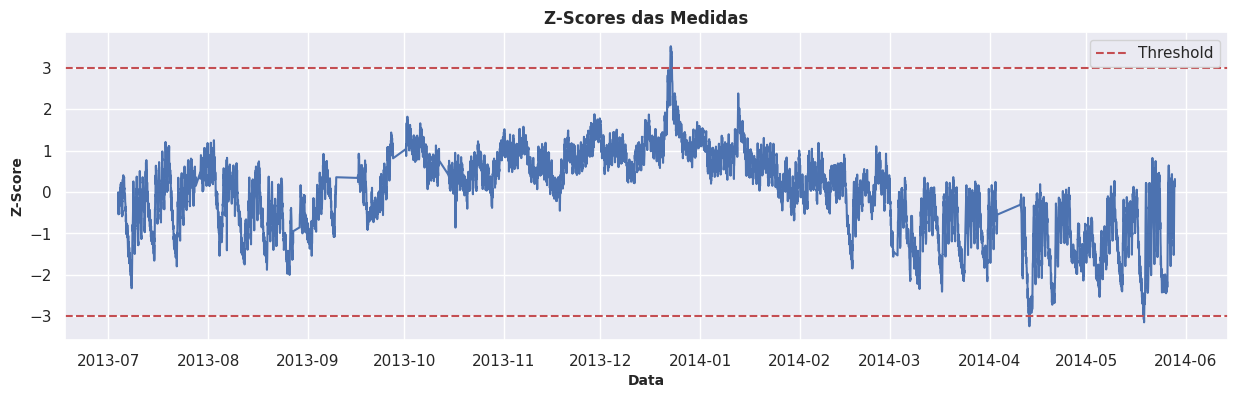

In [17]:
df_plot = DadosBase[["timestamp",'value']].copy()
df_plot = df_plot.set_index('timestamp')

z_scores = (df_plot['value'] - df_plot['value'].mean()) / df_plot['value'].std()
threshold = 3

plt.figure(figsize=(15, 4))
plt.plot(z_scores)

plt.title("Z-Scores das Medidas", fontsize=12, fontweight="bold" )
plt.ylabel('Z-Score', fontweight="bold", fontsize=10)
plt.xlabel ('Data', fontweight="bold", fontsize=10)

# plt.xticks(rotation=45)
plt.axhline(y=threshold, color='r', linestyle='--', label='Threshold')
plt.axhline(y=-threshold, color='r', linestyle='--')
plt.legend()
plt.grid(True)

plt.show()

#### **6.0) Identificando os Dados Fora do Limiar**

In [18]:
dfDados = DadosBase[["timestamp",'value']].copy()
dfDados ["ZScores"] = (dfDados['value'] - dfDados['value'].mean()) / dfDados['value'].std()
LimiarSuperior = 3
LimiarInferior = -3
dfDados.drop(dfDados[(dfDados['ZScores'] >LimiarSuperior) | (dfDados['ZScores'] < LimiarInferior)].index, inplace=True)
qtyZScore = len (DadosBase) - len(dfDados)
qtyZScore

19

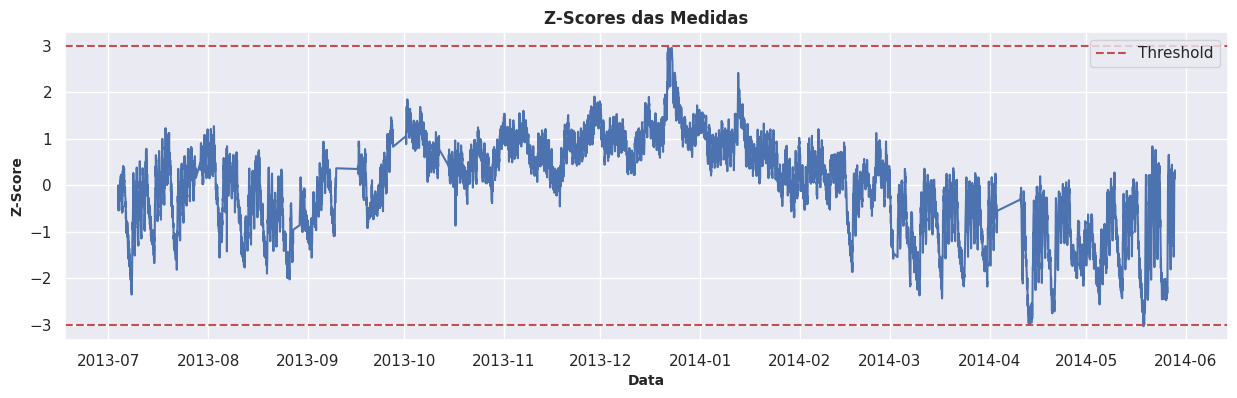

In [19]:
df_plot = dfDados[["timestamp",'value']].copy()
df_plot = df_plot.set_index('timestamp')

z_scores = (df_plot['value'] - df_plot['value'].mean()) / df_plot['value'].std()
# threshold = 3

plt.figure(figsize=(15, 4))
plt.plot(z_scores)

plt.title("Z-Scores das Medidas", fontsize=12, fontweight="bold" )
plt.ylabel('Z-Score', fontweight="bold", fontsize=10)
plt.xlabel ('Data', fontweight="bold", fontsize=10)

plt.axhline(y=threshold, color='r', linestyle='--', label='Threshold')
plt.axhline(y=-threshold, color='r', linestyle='--')
plt.legend()
plt.grid(True)

plt.show()

#### **8.0) IQR**

IQR =  35


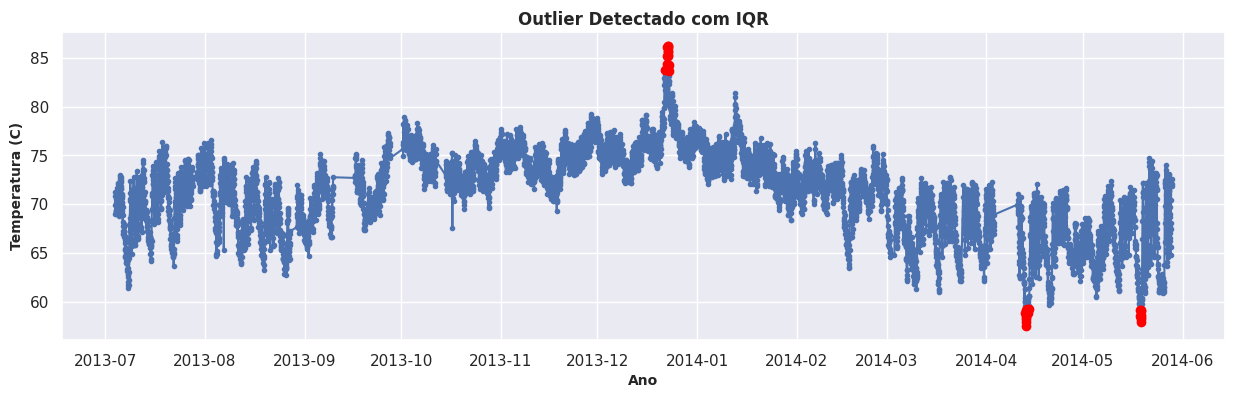

In [20]:
df_plot = DadosBase[["timestamp",'value']].copy()
df_plot = df_plot.set_index('timestamp')
idx_iqr = detect_outliers_iqr(df_plot, ['value'])
print ( "IQR = ", len(idx_iqr) )

plt.figure(figsize=(15, 4))

plt.plot(df_plot['value'], marker = '.')
for iAux in range (0, len(idx_iqr)):
    plt.plot(df_plot[df_plot.index==idx_iqr[iAux]] , 'o', color = 'red' )

plt.title("Outlier Detectado com IQR", fontsize=12, fontweight="bold" )
plt.ylabel('Temperatura (C)', fontweight="bold", fontsize=10)
plt.xlabel ('Ano', fontweight="bold", fontsize=10)
plt.show ()


In [21]:
df_plot = DadosBase[["timestamp",'value']].copy()
df_plot = df_plot.set_index('timestamp')
Media=detect_outliers_normal(df_plot, ['value'])

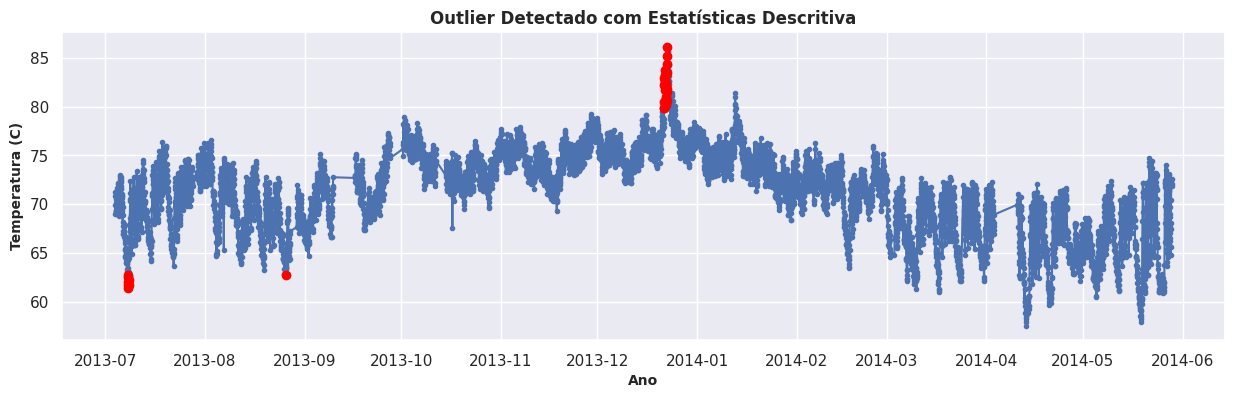

In [22]:

plt.figure(figsize=(15, 4))

plt.plot(df_plot['value'], marker = '.')
for iAux in range (0, len(idx_iqr)):
    plt.plot(df_plot[df_plot.index==Media[iAux]] , 'o', color = 'red' )

plt.title("Outlier Detectado com Estatísticas Descritiva", fontsize=12, fontweight="bold" )
plt.ylabel('Temperatura (C)', fontweight="bold", fontsize=10)
plt.xlabel ('Ano', fontweight="bold", fontsize=10)
plt.show ()

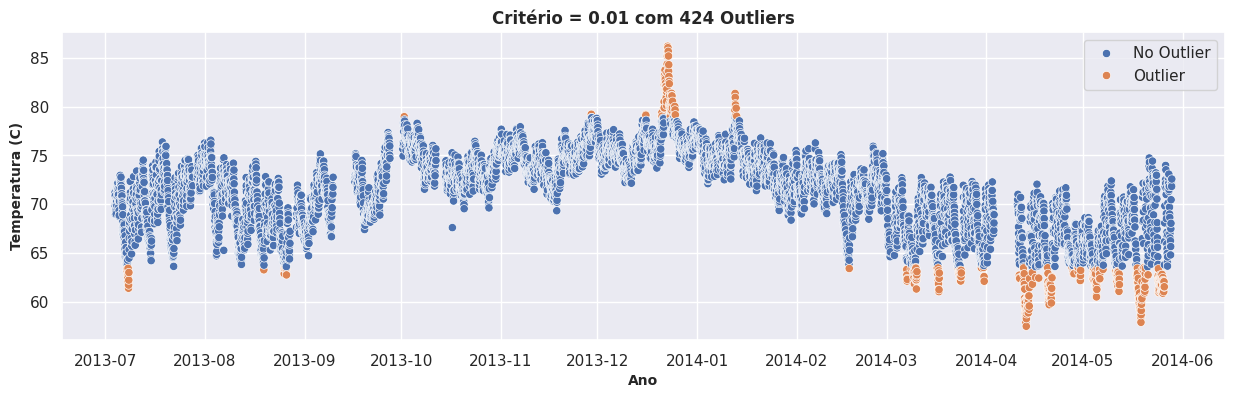

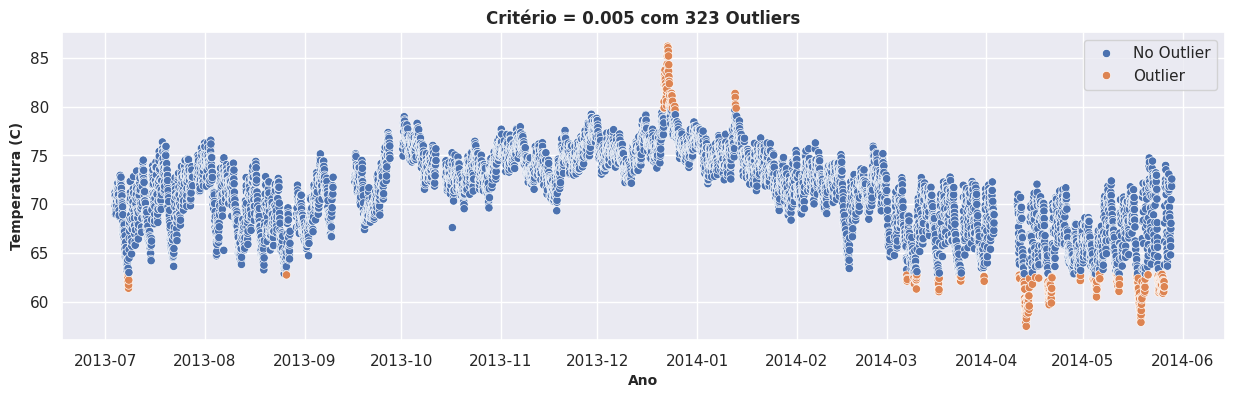

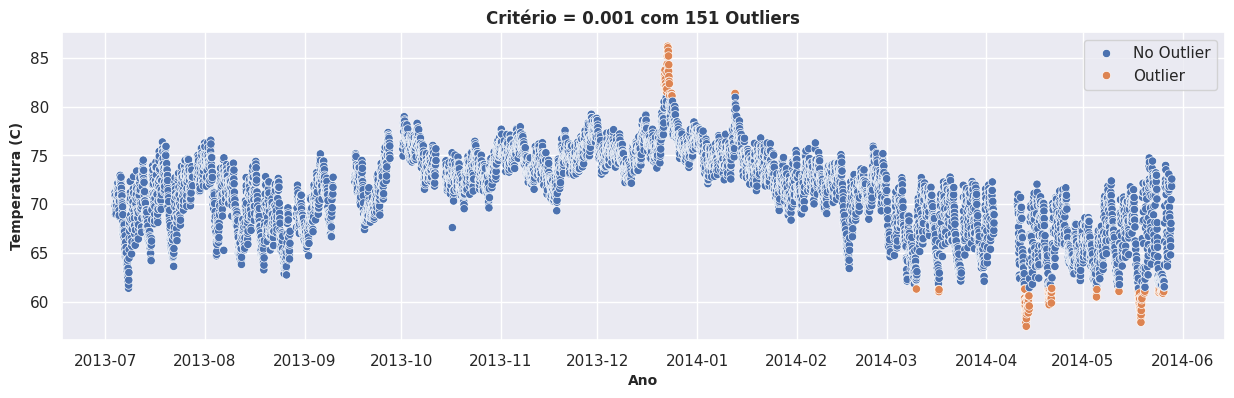

In [23]:
df_plot = DadosBase[["timestamp",'value']].copy()
df_plot = df_plot.set_index('timestamp')
Array = df_plot['value'].to_numpy()

for i, c in enumerate([0.01, 0.005, 0.001]): 
    mask = univariate_chauvenet(data_points=Array, criterion=c)
    plt.figure(figsize=(15, 4))
    sns.scatterplot (
                        data=df_plot, 
                        x='timestamp', 
                        y='value', 
                        hue=np.where(mask, 'Outlier', 'No Outlier'),
                        hue_order=['No Outlier', 'Outlier']
                    ) 
    
    strTitulo = f'Critério = {c} com {sum(mask)} Outliers'
    plt.title(strTitulo, fontsize=12, fontweight="bold" )
    plt.ylabel('Temperatura (C)', fontweight="bold", fontsize=10)
    plt.xlabel ('Ano', fontweight="bold", fontsize=10)

    plt.show()


In [24]:
DadosBase = pd.read_csv ( Arquivo ) 
DadosBase = DadosBase.dropna(how = 'any', axis = 0)
dfOriginal = DadosBase.copy()

In [25]:
DadosBase['timestamp'] = pd.to_datetime(DadosBase['timestamp'])
DadosBase["Date"] = DadosBase['timestamp'].dt.date
DadosBase['Date'] = pd.to_datetime(DadosBase['Date'])

In [26]:
X= DadosBase.copy()
X = X.drop (columns="timestamp")
X = X.drop (columns="Date")


In [27]:
mad = MAD(threshold=3)
mad.fit(X)
Lista = mad.labels_ 

df_plot = DadosBase[["timestamp",'value']].copy()
df_plot = df_plot.set_index('timestamp')


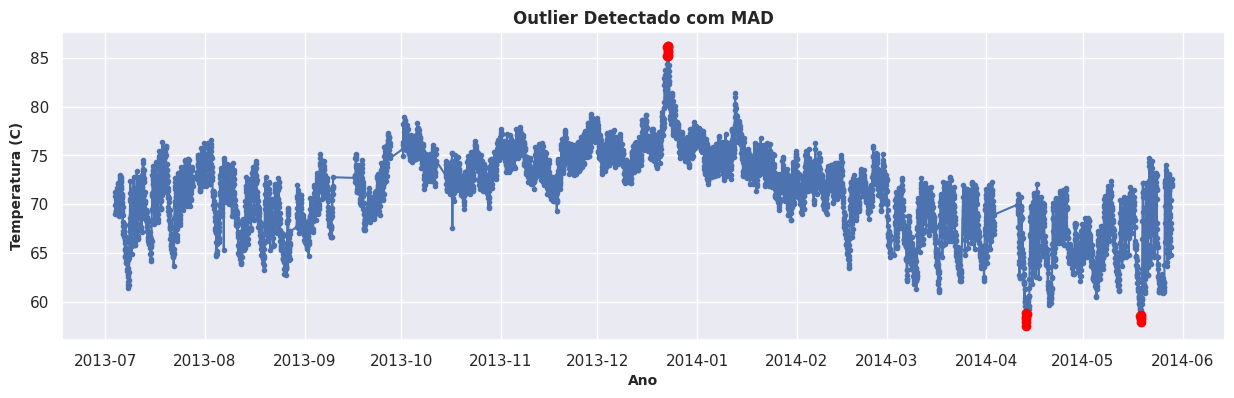

Elemento =  21


In [28]:
plt.figure(figsize=(15, 4))
NumeroElementos = 1
plt.plot(df_plot['value'], marker = '.')
for iAux in range (0, len(Lista)):
    if (Lista[iAux] == 1):
        NumeroElementos += 1
        plt.plot(df_plot.loc[DadosBase.index==iAux][['value']] , 'o', color = 'red' )

plt.title("Outlier Detectado com MAD", fontsize=12, fontweight="bold" )
plt.ylabel('Temperatura (C)', fontweight="bold", fontsize=10)
plt.xlabel ('Ano', fontweight="bold", fontsize=10)
plt.show ()

print ( "Elemento = ", NumeroElementos)

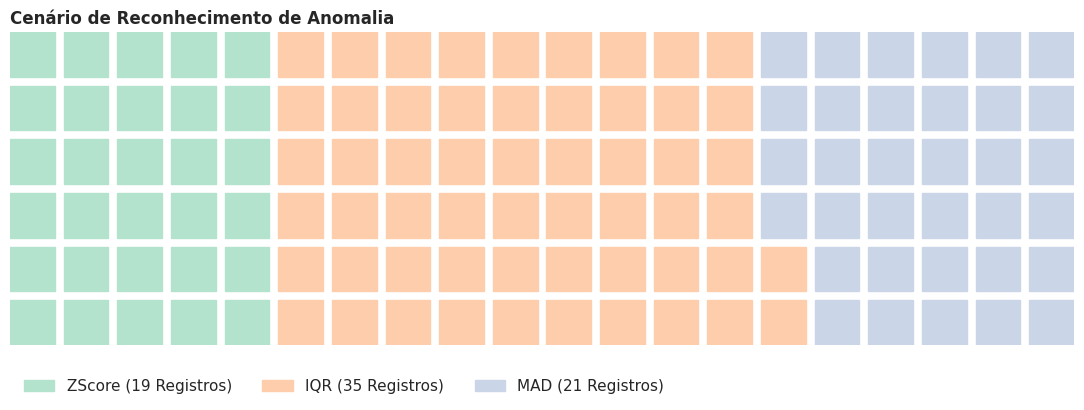

In [29]:
DadosTotais =   {
                    'ZScore': 19, 
                    'IQR': 35,
                    'MAD': 21                
                }

WaffleChart ( 
                DadosTotais, iLargura=11, iLinhas = 6,
                strTitulo='Cenário de Reconhecimento de Anomalia' 
            )
